<a href="https://colab.research.google.com/github/xFlodz/university/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0%20%E2%84%9611%20%D0%A0%D0%B0%D0%B1%D0%BE%D1%82%D0%B0%20%D1%81%20%D1%80%D0%B0%D1%81%D1%82%D1%80%D0%BE%D0%B2%D1%8B%D0%BC%D0%B8%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%BC%D0%B8%20%D0%B2%20Rasterio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №3. Работа с растровыми данными в Rasterio**

---

**Данные для обработки:**

- Одноканальное изображение (ЦМР): https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif
- Мультиспектральное изображение (Landsat): https://github.com/opengeos/datasets/releases/download/raster/cog.tif

### **Задание 1. Чтение и исследование растровых данных**



1. Откройте одноканальное изображение ЦМР с использованием `rasterio`.


In [1]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling


dem_path = "https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif"
ms_path  = "https://github.com/opengeos/datasets/releases/download/raster/cog.tif"


def print_raster_metadata(path: str):
    """
    Извлекает и отображает основные метаданные растрового изображения.
    """
    with rasterio.open(path) as src:
        print("=== Основные метаданные растра ===")
        print(f"Имя файла:            {src.name}")
        print(f"Ширина (px):          {src.width}")
        print(f"Высота (px):          {src.height}")
        print(f"Количество каналов:   {src.count}")
        print(f"Типы данных каналов:  {src.dtypes}")  # список типов данных

        print("\n=== Геопространственные метаданные ===")
        print(f"CRS (система координат): {src.crs}")
        print(f"Разрешение (pixel size): {src.res}")
        print(f"Аффинное преобразование: {src.transform}")

        print("\n=== Границы растра ===")
        print(f"Bounds: {src.bounds}")

        print("\n=== Индексы каналов ===")
        print(f"Channels: {src.indexes}")
        print("\n\n")

def show_dem(path: str, cmap: str = "terrain"):
  """
  Визуализирует одноканальное изображение ЦМР с пользовательской цветовой картой.
  """
  with rasterio.open(path) as src:
      dem = src.read(1)     # читаем единственный канал

  plt.figure(figsize=(10, 8))
  plt.imshow(dem, cmap=cmap)
  plt.colorbar(label="Elevation")
  plt.title("Цифровая Модель Рельефа (DEM)")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.tight_layout()
  plt.show()

def show_multispectral(path: str, bands, cmap="gray"):
    """
    Визуализирует мультиспектральное изображение:
    - если bands — один канал, выводит его в оттенках серого или указанной cmap
    - если bands — список из 3 каналов, строит RGB композит

    bands: int или list[int]
    """

    # Приводим bands к списку
    if isinstance(bands, int):
        bands = [bands]

    with rasterio.open(path) as src:
        # Проверка доступности каналов
        for b in bands:
            if b < 1 or b > src.count:
                raise ValueError(f"Канал {b} недоступен. В изображении каналов: {src.count}")

        # Загружаем каналы
        data = src.read(bands)

    plt.figure(figsize=(10, 8))

    # --- 1) Один канал ---
    if len(bands) == 1:
        plt.imshow(data[0], cmap=cmap)
        plt.colorbar(label=f"Band {bands[0]}")
        plt.title(f"Landsat Band {bands[0]}")
        plt.axis("off")
        plt.show()
        return

    # --- 2) RGB (3 канала) ---
    if len(bands) == 3:
        # Нормализация к диапазону [0, 1] для корректной визуализации
        rgb = np.zeros_like(data, dtype="float32")
        for i in range(3):
            band = data[i]
            band_min, band_max = np.percentile(band, (2, 98))
            rgb[i] = np.clip((band - band_min) / (band_max - band_min), 0, 1)

        rgb = np.transpose(rgb, (1, 2, 0))  # (bands, h, w) → (h, w, bands)

        plt.imshow(rgb)
        plt.title(f"RGB Composite (bands {bands})")
        plt.axis("off")
        plt.show()
        return

    # --- 3) Другие случаи ---
    raise ValueError("Нужно передать либо 1 канал, либо 3 канала для RGB.")

# Функция для нормализации канала в диапазон от 0 до 1
def normalize(band):
    band_min = band.min()
    band_max = band.max()
    band_norm = (band - band_min) / (band_max - band_min)
    return band_norm

2. Извлеките и выведите метаданные растра, включая СК, разрешение, границы, количество каналов и типы данных.


In [3]:
print_raster_metadata(dem_path)

=== Основные метаданные растра ===
Имя файла:            https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif
Ширина (px):          4269
Высота (px):          3113
Количество каналов:   1
Типы данных каналов:  ('int16',)

=== Геопространственные метаданные ===
CRS (система координат): EPSG:3857
Разрешение (pixel size): (90.0, 89.99579177642138)
Аффинное преобразование: | 90.00, 0.00,-13442488.34|
| 0.00,-90.00, 4668371.58|
| 0.00, 0.00, 1.00|

=== Границы растра ===
Bounds: BoundingBox(left=-13442488.3428, bottom=4388214.6777, right=-13058278.3428, top=4668371.5775)

=== Индексы каналов ===
Channels: (1,)





3. Отобразите ширину и высоту растра, а также типы данных пикселей, чтобы понять размеры сетки и структуру данных.

In [4]:
print_raster_metadata(ms_path)

=== Основные метаданные растра ===
Имя файла:            https://github.com/opengeos/datasets/releases/download/raster/cog.tif
Ширина (px):          343
Высота (px):          206
Количество каналов:   4
Типы данных каналов:  ('float64', 'float64', 'float64', 'float64')

=== Геопространственные метаданные ===
CRS (система координат): EPSG:4326
Разрешение (pixel size): (8.983152841195215e-05, 8.983152841195215e-05)
Аффинное преобразование: | 0.00, 0.00, 6.86|
| 0.00,-0.00, 53.42|
| 0.00, 0.00, 1.00|

=== Границы растра ===
Bounds: BoundingBox(left=6.860074498707138, bottom=53.39783678168941, right=6.890886712952438, top=53.41634207654228)

=== Индексы каналов ===
Channels: (1, 2, 3, 4)





---



### **Задание 2. Визуализация и манипулирование растровыми каналами**



1. Визуализируйте одноканальное изображение ЦМР с использованием пользовательской цветовой карты (например, cmap='terrain').


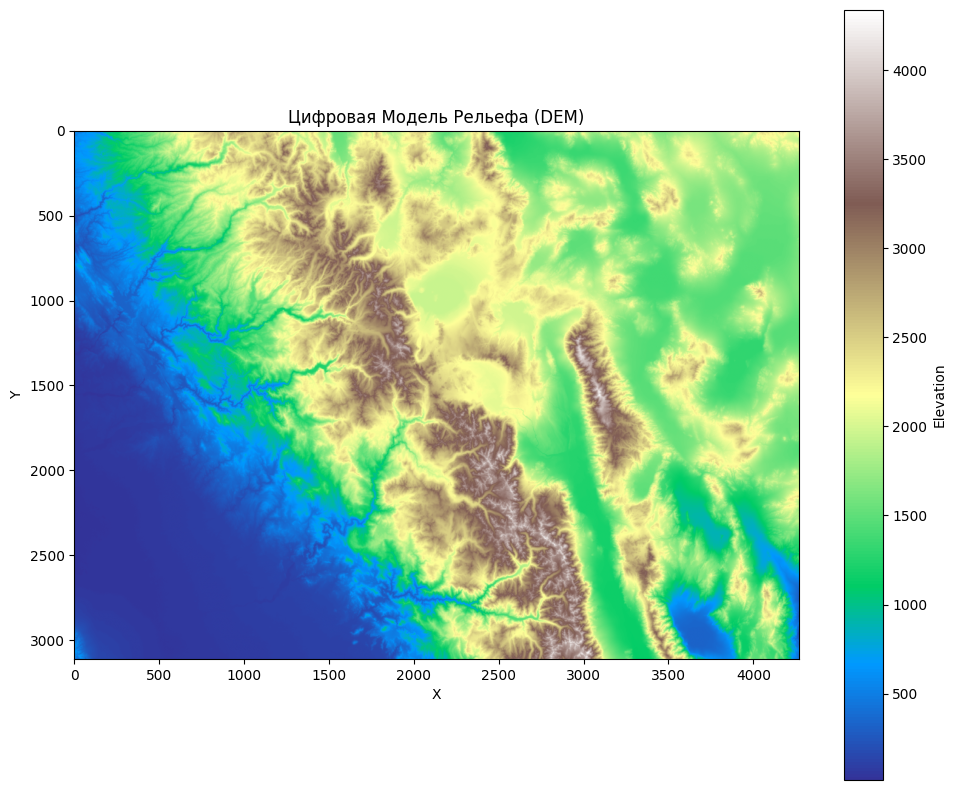

In [5]:
show_dem(dem_path, cmap="terrain")

2. Откройте мультиспектральное изображение и визуализируйте первый канал с использованием подходящей цветовой карты.


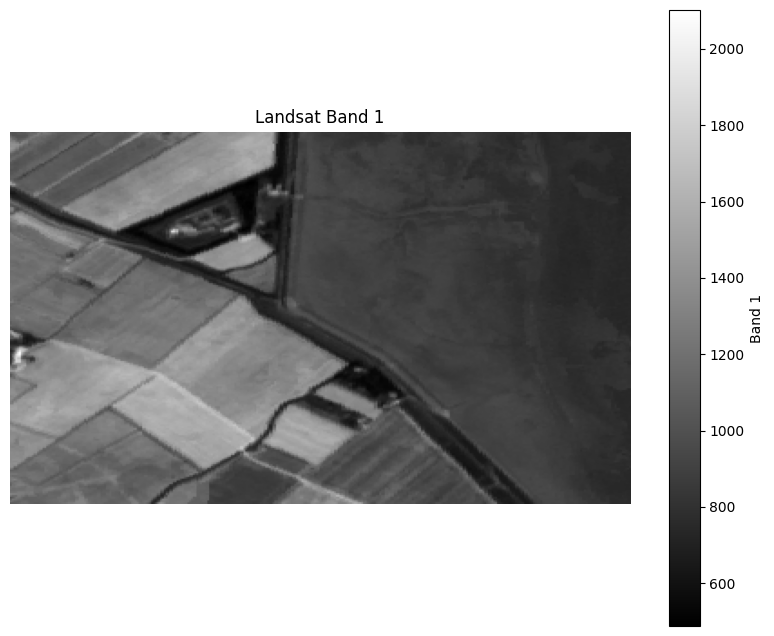

In [6]:
show_multispectral(ms_path, 1)

3. Объедините несколько каналов из мультиспектрального изображения (например, Красный, Зеленый и Синий) и совместите их в один массив для создания RGB-композитного изображения.

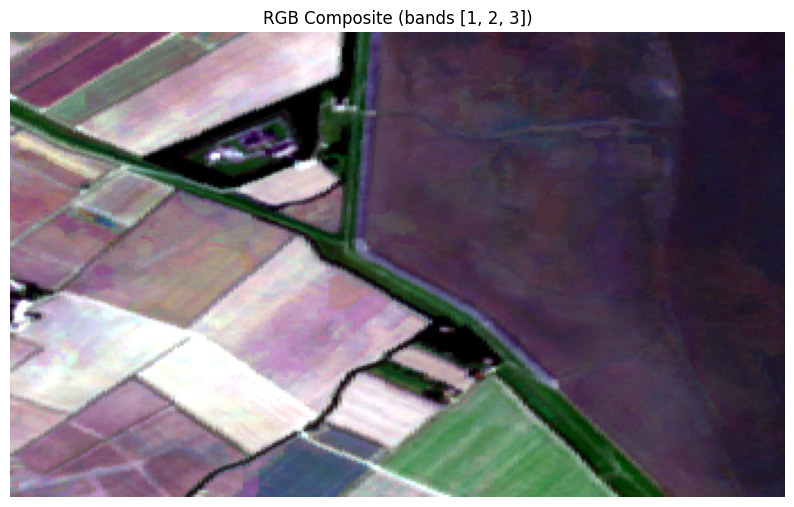

In [9]:
show_multispectral(ms_path, [1, 2, 3])

---



### **Задание 3. Обрезка растра с использованием индексации массива**



1. Откройте мультиспектральное изображение и обрежьте его с использованием спискового среза (указав диапазоны строк и столбцов).


In [22]:
row_start, row_end = 200, 900
col_start, col_end = 300, 1500

data = None
with rasterio.open(ms_path) as src:
    data = src.read()

cropped = data[:, row_start:row_end, col_start:col_end]

print("Исходная форма:", data.shape)
print("Обрезанная форма:", cropped.shape)

Исходная форма: (4, 206, 343)
Обрезанная форма: (4, 6, 43)


2. Визуализируйте обрезанную часть изображения с использованием matplotlib, чтобы убедиться в корректном результате.


>*Примечание:*
>
> При работе с многоканальными растровыми изображениями, особенно в формате COG.TIFF (Cloud Optimized GeoTIFF), может возникнуть проблема с некорректным отображением псевдоцветного изображения. Это связано с тем, что разные каналы могут иметь различные диапазоны значений пикселей.
>
> Для корректной визуализации на шаге 2 необходимо применить нормализацию к каждому каналу перед отображением.



Включите следующую функцию в ваш код:

```python
# Функция для нормализации канала в диапазон от 0 до 1
def normalize(band):
    band_min = band.min()
    band_max = band.max()
    band_norm = (band - band_min) / (band_max - band_min)
    return band_norm
```

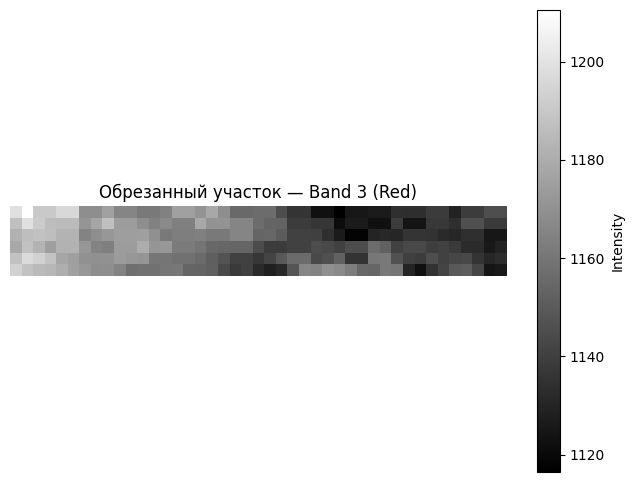

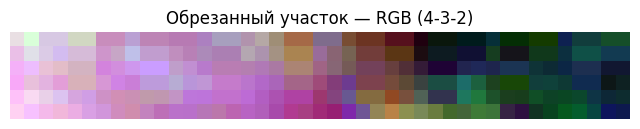

In [24]:
plt.figure(figsize=(8, 6))
plt.imshow(cropped[2], cmap="gray")
plt.title("Обрезанный участок — Band 3 (Red)")
plt.colorbar(label="Intensity")
plt.axis("off")
plt.show()

r = cropped[3].astype(float)
g = cropped[2].astype(float)
b = cropped[1].astype(float)

rgb = np.dstack([normalize(r), normalize(g), normalize(b)])

plt.figure(figsize=(8, 6))
plt.imshow(rgb)
plt.title("Обрезанный участок — RGB (4-3-2)")
plt.axis("off")
plt.show()

3. Сохраните обрезанное подмножество растра в новый файл с именем `clipped_multispectral.tif`.

In [25]:
profile = None
with rasterio.open(ms_path) as src:
  profile = src.profile.copy()

# Обновляем профиль под новый размер
profile.update({
    "height": cropped.shape[1],     # new height
    "width": cropped.shape[2],      # new width
    "count": cropped.shape[0],      # number of bands
    "driver": "GTiff"
})

with rasterio.open("clipped_multispectral.tif", "w", **profile) as dst:
    dst.write(cropped)

In [26]:
with rasterio.open("clipped_multispectral.tif") as t:
    print(t.width, t.height, t.count)
    print(t.transform)
    print(t.crs)


43 6 4
| 0.00, 0.00, 6.86|
| 0.00,-0.00, 53.42|
| 0.00, 0.00, 1.00|
EPSG:4326


---



### **Задание 4. Вычисление NDWI (калькуляция каналов)**



1. Откройте мультиспектральное изображение и извлеките каналы Green (Зеленый) и Ближний инфракрасный (NIR).


In [27]:
green = None
nir = None

with rasterio.open(ms_path) as src:
    # Band numbers (1-based index):
    green_band_index = 3     # Green
    nir_band_index   = 4     # Near Infrared (NIR)

    green = src.read(green_band_index)
    nir   = src.read(nir_band_index)

print("Green shape:", green.shape)
print("NIR shape:", nir.shape)


Green shape: (206, 343)
NIR shape: (206, 343)


2. Вычислите Нормализованный разностный водный индекс ([NDWI](https://en.wikipedia.org/wiki/Normalized_difference_water_index)) по формуле:

    NDWI = (Green - NIR) / (Green + NIR)

In [28]:
ndwi = (green - nir) / (green + nir)

# Защита от деления на ноль
ndwi = np.where((green + nir) == 0, 0, ndwi)

ndwi_water = np.where(ndwi > 0, ndwi, np.nan)

print("Статистика:")
print("Min:", np.nanmin(ndwi))
print("Max:", np.nanmax(ndwi))
print("Mean:", np.nanmean(ndwi))

Статистика:
Min: -0.6077865092345126
Max: 0.5341717851223555
Mean: -0.018645080572398984


3. Визуализируйте результат NDWI с использованием цветовой карты, подходящей для воды (например, cmap='Blues'), чтобы выделить водные объекты.


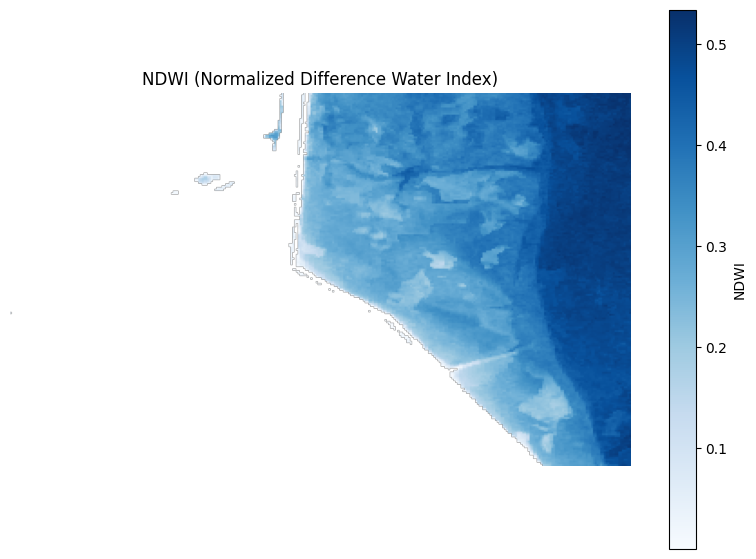

In [29]:
plt.figure(figsize=(10, 7))
plt.imshow(ndwi_water, cmap="Blues")
plt.colorbar(label="NDWI")
plt.title("NDWI (Normalized Difference Water Index)")
plt.axis("off")
plt.show()



4. Сохраните полученное изображение NDWI как новый растровый файл с именем ndwi.tif.

In [30]:
profile = None
with rasterio.open(ms_path) as src:
    profile = src.profile.copy()
    profile.update({
        "count": 1,                 # только 1 канал
        "dtype": "float32",         # NDWI хранится как float
    })

with rasterio.open("ndwi.tif", "w", **profile) as dst:
    dst.write(ndwi, 1)

---



### **Задание 5. Перепроецирование растровых данных**



1. Перепроецируйте одноканальный растр ЦМР из его исходной СК в EPSG:4326 (WGS 84) с использованием функции `rasterio.warp.reproject`.


2. Сохраните перепроецированный растр в новый файл GeoTIFF с именем `reprojected_dem.tif`.


In [34]:
dst_reprojected_dem_path = "reprojected_dem.tif"
dst_crs = "EPSG:4326"

with rasterio.open(dem_path) as src:
    src_transform = src.transform
    src_crs = src.crs
    src_width = src.width
    src_height = src.height

    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs, src_width, src_height, *src.bounds
    )

    dst_profile = src.profile.copy()
    dst_profile.update({
        "crs": dst_crs,
        "transform": dst_transform,
        "width": dst_width,
        "height": dst_height
    })

    with rasterio.open(dst_reprojected_dem_path, "w", **dst_profile) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )


3. Визуализируйте как исходный, так и перепроецированный наборы данных ЦМР, чтобы сравнить, как перепроецирование влияет на пространственное покрытие и разрешение.

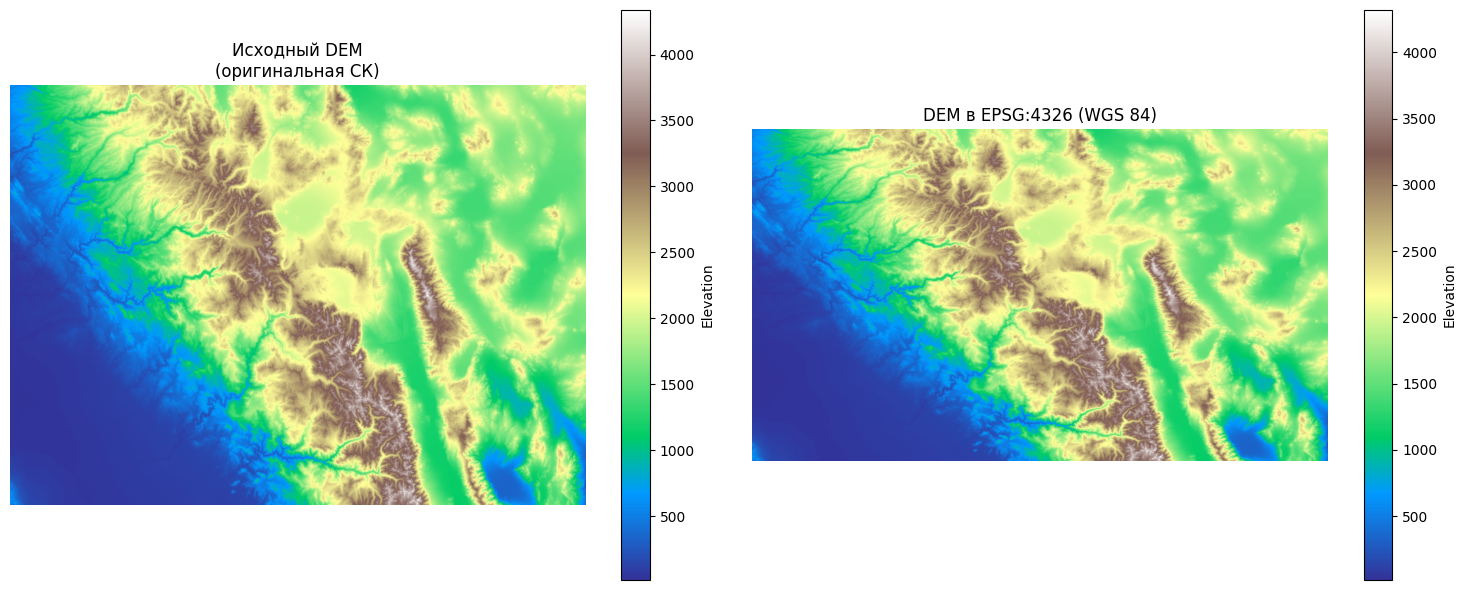

In [35]:
dem_original = None
with rasterio.open(dem_path) as src:
    dem_original = src.read(1)

dem_reprojected = None
with rasterio.open(dst_reprojected_dem_path) as src:
    dem_reprojected = src.read(1)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(dem_original, cmap="terrain")
plt.title("Исходный DEM\n(оригинальная СК)")
plt.colorbar(label="Elevation")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(dem_reprojected, cmap="terrain")
plt.title("DEM в EPSG:4326 (WGS 84)")
plt.colorbar(label="Elevation")
plt.axis("off")

plt.tight_layout()
plt.show()

---